# Composite System Evolution
Here we try to model the evolution one system at a time, saving the intermediate state of ancillas

In [3]:
include("./modules/OpticalCavity.jl")
include("./modules/Thermodynamics.jl")
include("./modules/Phaseonium.jl")
include("./modules/BosonicOperators.jl")
include("./modules/Measurements.jl")

using LinearAlgebra
using ProgressBars
using Plots
using LaTeXStrings
# Saving the output matrix
using Serialization
using NPZ

using .OpticalCavity
using .Thermodynamics
using .Phaseonium
using .BosonicOperators
using .Measurements

include("./src/RoutineFunctions.jl")
Threads.nthreads()

LoadError: LoadError: ParseError:
[90m# Error @ [0;0m]8;;file://G:/UNIPA/DOTTORATO/PHASEONIUM/thermo-phaseonium/julia/modules/Measurements.jl#42:1\[90mG:\UNIPA\DOTTORATO\PHASEONIUM\thermo-phaseonium\julia\modules\Measurements.jl:42:1[0;0m]8;;\
    N = diagm(
[48;2;120;70;70m[0;0mend
[90m└ ── [0;0m[91mExpected `)`[0;0m
in expression starting at G:\UNIPA\DOTTORATO\PHASEONIUM\thermo-phaseonium\julia\modules\Measurements.jl:42

In [7]:
N = Diagonal(0:9)

10×10 Diagonal{Int64, UnitRange{Int64}}:
 0  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  2  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  3  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  4  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  5  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  6  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  7  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  8  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  9

In [2]:
function _check(ρ)
    println("System after the stroke:")
    if !checkdensity(ρ)
        throw(DomainError(ρ))
    end
    println("Final Temperature of the System: $(Measurements.temperature(ρ, ω))")
end

function measure_and_plot(system_evolution, cavity_evolution, title)
    temperatures = []
    entropies = []
    for (i, ρ) in enumerate(system_evolution)
        cavity_len = cavity_evolution isa Real ? cavity_evolution : cavity_evolution[i]
        local ω = α0 / cavity_len
        t = round(Measurements.temperature(ρ, ω), digits=5)
        ent = round(Measurements.entropy_vn(ρ), digits=5)
        
        push!(temperatures, t)
        push!(entropies, ent)
    end
    
    g = plot(entropies, temperatures, label="Stroke")
    # Plot starting point
    scatter!(g, [entropies[1]], [temperatures[1]], label="Start", mc="blue", ms=5)
    # Plot ending point
    scatter!(g, [entropies[end]], [temperatures[end]], label="End", mc="red", ms=5)
    title!(title)
    xlabel!("Entropy")
    ylabel!("Temperature")
    
    return g
end
;

In [3]:
const NDIMS = 20
const Ω = 1.0
const Δt = 1e-2

T_initial = 1.0
T_heating = 1.5
T_cooling = 0.25

# Create a Cavity
α0 = π
l0 = 1.0
expanding_force = 0.5
compressing_force = 2.5
cavity = Cavity(1.0, 1.0, l0, α0, expanding_force)
ω = α0 / l0

ρt = thermalstate(NDIMS, ω, T_initial)
println(
    "Initial Temperature of the Cavity:
    $(Measurements.temperature(ρt, ω))")
# Joint system
ρ_tot = kron(ρt, ρt)

# Jump Operators
a = BosonicOperators.destroy(NDIMS)
ad = BosonicOperators.create(NDIMS)

# Create Phaseonium atoms
# For thermal (diagonal) phaseoniums, the Master Equation is the same as having ϕ=π/2
# Heating
ϕ_h = π/3
α_h = Phaseonium.alpha_from_temperature(T_heating, ϕ_h, ω) 

ga_h, gb_h = Phaseonium.dissipationrates(α_h, ϕ_h)
println(
    "Apparent Temperature carried by Hot Phaseonium atoms: 
    $(Phaseonium.finaltemperature(ω, ga_h, gb_h))")

# Cooling
ϕ_c = π/4
α_c = Phaseonium.alpha_from_temperature(T_cooling, ϕ_c, ω) 

ga_c, gb_c = Phaseonium.dissipationrates(α_c, ϕ_c)
println(
    "Apparent Temperature carried by Cold Phaseonium atoms: 
    $(Phaseonium.finaltemperature(ω, ga_c, gb_c))")

# Time Evolution loop
const TT = 100000  # Thermalization Time

system_evolution = []
;

Initial Temperature of the Cavity:
    1.0
Apparent Temperature carried by Hot Phaseonium atoms: 
    1.4999999999999998
Apparent Temperature carried by Cold Phaseonium atoms: 
    0.25


### One-step evolution
We calculare:
\begin{equation}
\frac{\rho_{n+1}-\rho_n}{\Delta t} = Tr_{\eta}\left\{ e^{-i\Delta t(H_S + H_\eta + V_n)}\rho_n\otimes\eta\, e^{i\Delta t(H_S + H_\eta + V_n)} \right\}
\end{equation}

with:

\begin{align}
&H_S = \hbar\omega\left(\hat{n}+\frac{1}{2}\right) \\
&H_\eta = \frac{\hbar\omega}{2} \left(\sigma^+_1\sigma^-_1 + \sigma^+_2\sigma^-_2\right) = \frac{\hbar\omega}{2}\left(\sigma_{z1}+\sigma_{z2}\right) \\
&V_n = \hbar\Omega \{ \hat{a}(\sigma_1^+ + \sigma_2^+) + \hat{a}^\dagger(\sigma_1^- + \sigma_2^-) \} =
     \hbar\Omega \{ \hat{a}\sigma^+ + \hat{a}^\dagger\sigma^- \}
\end{align}

and Kraus Operators
\begin{align}
    \hat E_0 &&= \sqrt{1 - \frac{\gamma_\alpha}{2} - \frac{\gamma_\beta}{2}}\, \mathbb{I}\,, \\[.5em]
    \hat E_1 &&= \sqrt{\frac{\gamma_\alpha}{2}}\,( \hat C{\otimes}\hat C{-2}\hat S{\otimes}\hat S^\dagger)\,, \\[.5em]
    \hat E_2 &&= \sqrt{\gamma_\alpha}\, (\hat S{\otimes} \hat C'{+}\hat C{\otimes} \hat S)\,,\\[.7em]
    \hat E_3 &&= \sqrt{\gamma_\beta}\,(\hat S^\dagger{\otimes}\hat C{+}\hat C'{\otimes} \hat S^\dagger) \,, \\[.5em]
    \hat E_4 &&= \sqrt{\frac{\gamma_\beta}{2}}\,(\hat C'{\otimes} C'{-2}\hat S^\dagger{\otimes} \hat S) \,.
\end{align}

Or, from the Master Equation:
\begin{equation}
\begin{split}
    \Delta\rho_n = \biggl[&
    \gamma_\alpha\left(\frac{1}{2} \mathcal{D}[C\otimes C - 2S\otimes S^\dagger]
    + \mathcal{D}[C\otimes S + S\otimes C']
    \right) \\[0.6em]
    &+\gamma_\beta\left( \frac{1}{2} \mathcal{D}[C'\otimes C'-2S^\dagger\otimes S] 
    + \mathcal{D}[C'\otimes S^\dagger+S^\dagger\otimes C]\right)
     \;\biggr]\rho_n
\,.\end{split} 
\end{equation}

In [4]:
function kraus_operators(α, ϕ)
    ga, gb = Phaseonium.dissipationrates(α, ϕ)
    
    C = BosonicOperators.C(Ω*Δt, NDIMS)
    Cp = BosonicOperators.Cp(Ω*Δt, NDIMS)
    S = BosonicOperators.S(Ω*Δt, NDIMS)
    Sd = BosonicOperators.Sd(Ω*Δt, NDIMS)
    
    E0 = sqrt(1 - ga/2 - gb/2) * kron(idd(NDIMS), idd(NDIMS))
    E1 = sqrt(ga/2) * (kron(C, C) -2 * kron(S, Sd))
    E2 = sqrt(ga) * (kron(S, Cp) + kron(C, S))
    E3 = sqrt(gb/2) * (kron(Cp, Cp) - 2 * kron(Sd, S))
    E4 = sqrt(gb) * (kron(Sd, C) + kron(Cp, Sd))
    
    return [E0, E1, E2, E3, E4]
end
;

function bosonic_operators(α, ϕ)
    
    C = BosonicOperators.C(Ω*Δt, NDIMS)
    Cp = BosonicOperators.Cp(Ω*Δt, NDIMS)
    S = BosonicOperators.S(Ω*Δt, NDIMS)
    Sd = BosonicOperators.Sd(Ω*Δt, NDIMS)
    
    return [C, Cp, S, Sd]
end
;

kraus = kraus_operators(α_h, ϕ_h);
bosonic = bosonic_operators(α_h, ϕ_h);

Isochoric Stroke


0.0%┣                                              ┫ 0/200 [00:00<00:00, -0s/it]
0.5%┣▏                                         ┫ 1/200 [00:01<Inf:Inf, InfGs/it]
1.0%┣▌                                              ┫ 2/200 [00:02<06:10, 2s/it]
1.5%┣▊                                              ┫ 3/200 [00:02<04:00, 1s/it]
2.0%┣█                                              ┫ 4/200 [00:03<03:17, 1s/it]
2.5%┣█▏                                             ┫ 5/200 [00:04<02:58, 1it/s]
3.0%┣█▍                                             ┫ 6/200 [00:04<02:44, 1it/s]
3.5%┣█▋                                             ┫ 7/200 [00:05<02:35, 1it/s]
4.0%┣█▉                                             ┫ 8/200 [00:05<02:28, 1it/s]
4.5%┣██▏                                            ┫ 9/200 [00:06<02:22, 1it/s]
5.0%┣██▎                                           ┫ 10/200 [00:07<02:18, 1it/s]
5.5%┣██▌                                           ┫ 11/200 [00:07<02:15, 1it/s]
6.0%┣██▊                    

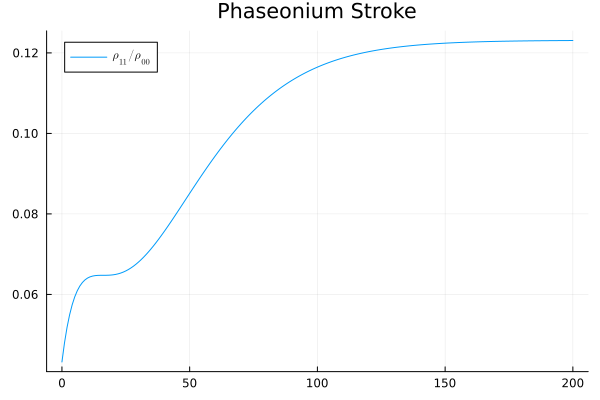

In [9]:
printed_steps = 200
stroke_evolution = Thermodynamics.phaseonium_stroke_2(ρ_tot, TT, bosonic, ga_h, gb_h; sampling_steps=printed_steps, verbose=4);
# stroke_evolution = Thermodynamics.phaseonium_stroke(ρ_tot, TT, kraus; sampling_steps=printed_steps, verbose=4);
append!(system_evolution, stroke_evolution);
ρ = stroke_evolution[end];
# Save this system
npzwrite("out_phaseoniumstroke_$TT.npy", ρ);
serialize("out_phaseoniumstroke_$(TT)_jl", ρ);

**Kraus Map**: [04:16<00:00, 1s/it]

In [10]:
Measurements.temperature(partial_trace(ρ, (NDIMS, NDIMS), 1), ω)

1.4999974862753331

In [13]:
ρ1_evolution = [chop!(partial_trace(ρ, (NDIMS, NDIMS), 2)) for ρ in stroke_evolution]
measure_and_plot(ρ1_evolution, cavity.length, "First Cavity Evolution");

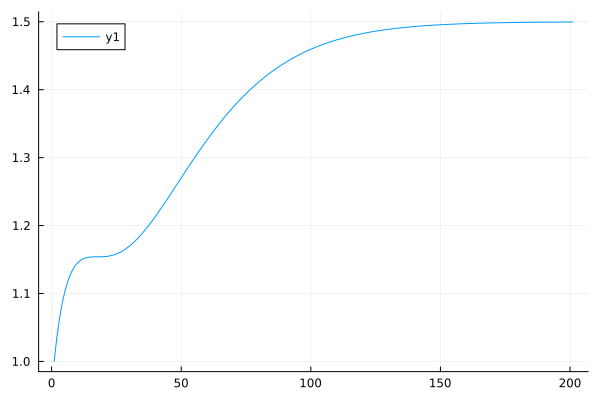

In [14]:
ρ1_temperatures = [round(Measurements.temperature(ρ, α0 / cavity.length), digits=5) for ρ in ρ1_evolution];
plot(ρ1_temperatures)